## Automatic Differentiation

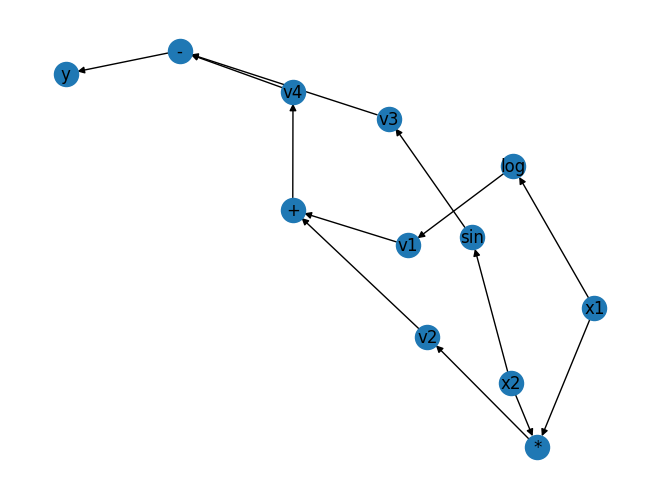

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../trengx')
import engine as te

# Create a directed graph
G = nx.DiGraph()
G.clear()

x1, _, v1 = te.op2(G, in_name='x1', op_name='log', out_name='v1')
_, x2, _, v2 = te.op1(G, in1_id=x1, in2_name='x2', op_name='*', out_name='v2')
_, _, _, v4 = te.op1(G, in1_id=v1, in2_id=v2, op_name='+', out_name='v4')
_, _, v3 = te.op2(G, in_id=x2, op_name='sin', out_name='v3')
_, _, _, y = te.op1(G, in1_id=v4, in2_id=v3, op_name='-', out_name='y')

# Create a mapping for the labels
labels = {node[0]: node[1]['name'] for node in G.nodes(data=True)}

# Draw the graph
nx.draw(G, labels=labels, with_labels=True)

plt.show()


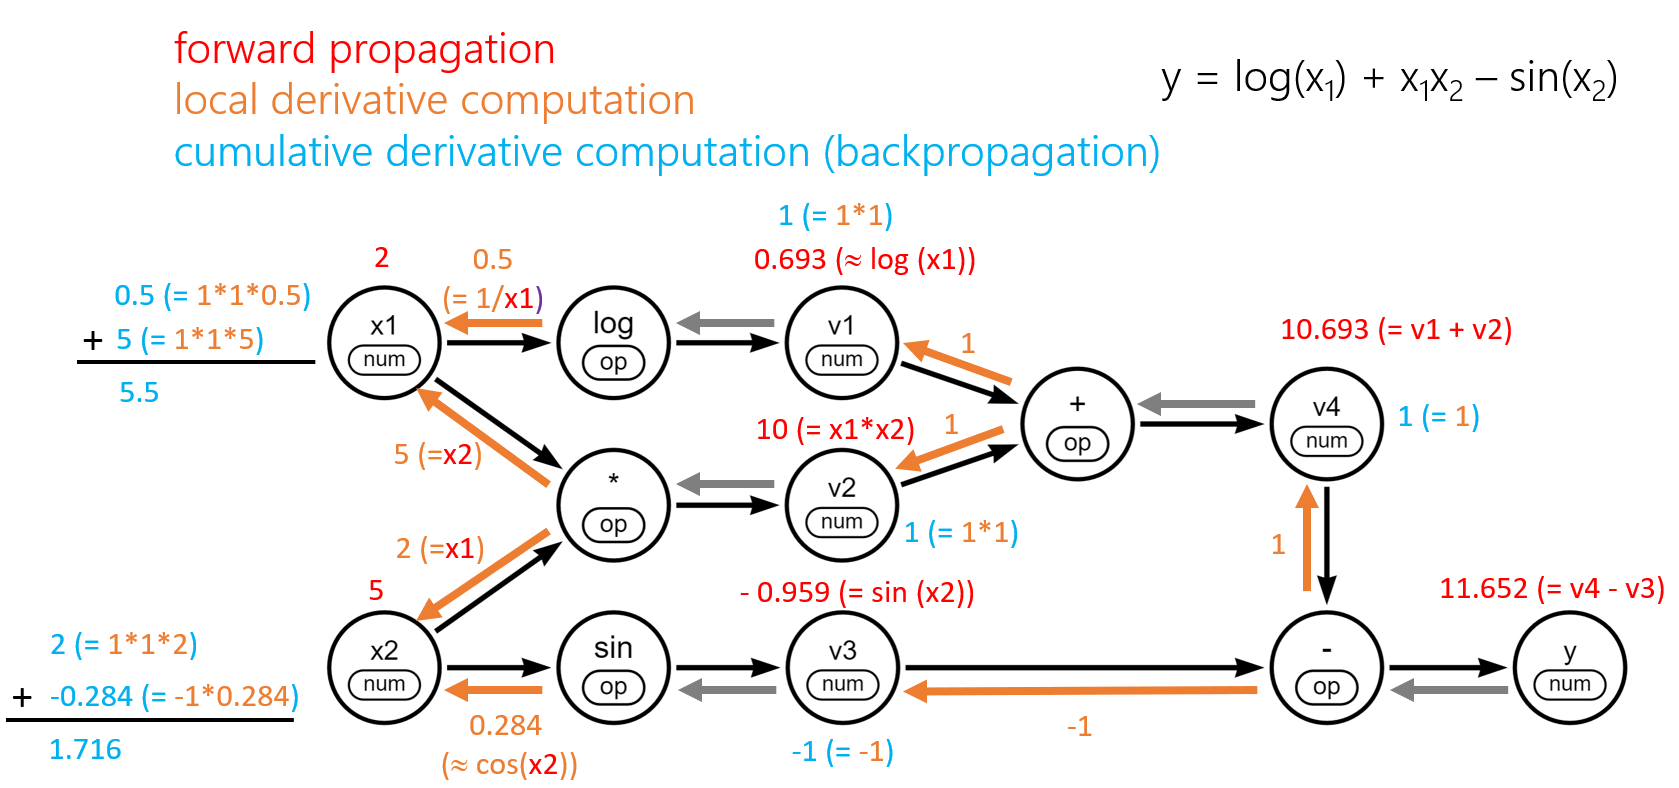

In [2]:
te.forward_propagate(G, x1, 2)
te.forward_propagate(G, x2, 5)
print("x1 value: ", G.nodes[x1]['value'])
print("x2 value: ", G.nodes[x2]['value'])
print("v1 value: ", G.nodes[v1]['value'])
print("v2 value: ", G.nodes[v2]['value'])
print("v3 value: ", G.nodes[v3]['value'])
print("v4 value: ", G.nodes[v4]['value'])
print("y value: ", G.nodes[y]['value'])


x1 value:  2
x2 value:  5
v1 value:  0.6931471805599453
v2 value:  10
v3 value:  -0.9589242746631385
v4 value:  10.693147180559945
y value:  11.652071455223084


In [3]:
# Compute gradients for path involving 'x1'
G.nodes[y]['grad'] = 1
te.backward_propagate(G, y)

print("x1 grad: ", G.nodes[x1]['grad'])
print("x2 grad: ", G.nodes[x2]['grad'])
print("v1 grad: ", G.nodes[v1]['grad'])
print("v2 grad: ", G.nodes[v2]['grad'])
print("v3 grad: ", G.nodes[v3]['grad'])
print("v4 grad: ", G.nodes[v4]['grad'])
print("y grad: ", G.nodes[y]['grad'])


x1 grad:  5.5
x2 grad:  1.7163378145367738
v1 grad:  1
v2 grad:  1
v3 grad:  -1
v4 grad:  1
y grad:  1
